In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Alpha Fund

We ought to create a portfolio that would give constant return regardless of the market returns. Later on, we can further update the portfolio such that

Expected Market Behavior  | Portfolio α | Portfolio β
-------------------|------------------ | ------------------
Increase with high chance     | Positive  | Positive
Unsure      | Positive | Zero
Decrease with high chance     | Positive | Negative

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import yfinance as yf
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Loading Data

We will be downloading data from yahoo fiance via yfinance API. Furthermore, we are using ~500 tickers in the S&P 500 index as of April 2023. Hence, if some tickers were not included in the index in the past, we will exclude such tickers.

Our initial strategy is to create a market-neutral portfolio that generates a positive alpha. In order to do so, we would first calculate the CAPM statistics from the past year, and then construct a long portfolio that consists of stocks with positive alpha and short portolifo with those of negative alpha. Then we will make a linear combination of the two portfolio to then create a portfolio of net-zero beta.

In [ ]:
ticker_group = []

# I have the s&p tickers saved in a separate file
with open('s_p500 tickers.txt', 'r') as f:
    for line in f:
        ticker_group.append(line[:-1])
market, bond = "SPY", "^IRX"
ticker_group.extend([market, bond])

In [ ]:
adj_close = yf.download(ticker_group, start="2009-01-01", ignore_tz=True).loc[:, "Adj Close"]

[*********************100%***********************]  505 of 505 completed


In [ ]:
adj_close.to_csv("15.417_Lab_3_Data.csv")

In [ ]:
adj_close.describe()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZT,^IRX
count,3613.000000,3613.000000,3613.000000,3613.000000,2607.000000,3613.000000,3613.000000,3613.000000,3613.000000,3613.000000,...,3613.000000,3613.000000,3613.000000,2912.000000,3613.000000,3613.000000,3613.000000,3613.000000,436.000000,3610.000000
mean,58.937274,23.474576,114.820837,48.819473,71.455734,72.328740,52.557116,25.394846,126.137187,179.359820,...,36.106985,58.358810,43.598263,58.367999,63.459082,93.284895,145.662090,30.723853,9.820252,0.676350
std,41.351094,14.760336,49.332002,49.750315,36.504280,38.053477,34.119211,13.939280,91.691883,172.292344,...,19.394157,15.606751,10.880040,30.392645,33.508992,33.216502,144.143844,14.369196,0.155273,1.083992
min,8.055532,1.857201,27.225859,2.377052,21.976082,11.500842,14.495208,5.011111,20.340618,15.980000,...,9.788217,26.564505,19.765032,19.741772,12.831426,28.368633,16.450001,5.349998,9.580000,-0.105000
25%,27.947735,10.596415,67.270988,14.210949,43.496359,34.142075,25.382021,13.186667,51.507622,35.169998,...,19.563229,50.567459,34.405766,31.842785,39.004055,57.161087,39.779999,19.251724,9.705000,0.043000
50%,39.424129,19.129999,125.113930,26.325047,64.706024,76.275780,38.391590,23.650000,95.728409,92.500000,...,32.032936,58.257919,42.768597,53.603306,53.251266,101.237282,81.250000,25.082186,9.750000,0.125000
75%,75.044891,37.131950,148.713058,55.353092,89.086292,91.000488,78.840431,32.660000,177.679413,288.739990,...,55.623955,63.231709,53.490131,78.185867,91.053650,116.705559,208.460007,42.341091,9.912500,0.999500
max,177.363708,56.988728,230.368698,180.683868,167.007950,173.455414,137.809662,77.019997,406.562866,688.369995,...,75.774223,118.339996,67.512856,135.543686,142.899994,170.799347,614.549988,71.756218,10.210000,5.123000


In [ ]:
adj_close.fillna(0, inplace=True)
adj_close

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZT,^IRX
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-02,10.516225,7.909603,30.849348,2.758535,0.000000,14.472869,18.395426,7.663333,25.679361,23.020000,...,11.390359,48.092957,26.296160,0.000000,17.383701,36.871284,21.030001,20.582848,0.000,0.085
2009-01-05,10.872375,7.853036,30.433691,2.874956,0.000000,14.749554,18.079453,7.597778,25.793766,23.129999,...,11.281537,48.087048,25.428963,0.000000,17.856319,36.111969,20.740000,20.031239,0.000,0.085
2009-01-06,11.740096,8.541239,30.478863,2.827537,0.000000,14.692586,17.488707,7.583333,25.473438,24.219999,...,11.136436,47.303600,24.751450,0.000000,17.823730,36.782993,21.260000,20.706347,0.000,0.130
2009-01-07,11.804849,8.560091,29.268023,2.766438,0.000000,14.611209,17.392532,7.461111,25.763252,24.230000,...,11.021566,46.095963,24.823725,0.000000,17.188141,35.591026,21.280001,18.590431,0.000,0.100
2009-01-08,11.882555,9.022037,29.367420,2.817809,0.000000,14.940787,17.584875,7.586667,25.503946,24.290001,...,11.166662,46.590801,25.121826,0.000000,17.106647,36.544579,20.629999,18.277575,0.000,0.080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-04,133.880005,13.510000,120.239998,165.789993,147.360001,166.589996,110.860001,72.919998,266.500000,335.829987,...,69.110001,106.040001,40.849998,106.330002,136.320007,136.630005,265.000000,19.930000,10.190,5.055
2023-05-05,133.300003,13.870000,123.769997,173.570007,148.029999,167.990005,111.260002,74.809998,265.649994,348.399994,...,69.570000,108.680000,41.299999,108.970001,137.490005,137.910004,273.799988,23.760000,10.190,5.080
2023-05-08,132.449997,14.360000,125.750000,173.500000,147.449997,168.210007,110.900002,76.139999,264.820007,344.059998,...,69.320000,109.110001,41.320000,107.339996,136.529999,137.440002,277.859985,24.260000,10.195,5.083


In [ ]:
# adj_close.dropna(axis=1, inplace=True)

In [ ]:
bond_price = yf.download(bond, start="2009-01-01", ignore_tz=True).loc[:, "Adj Close"]

[*********************100%***********************]  1 of 1 completed


In [ ]:
adj_close["SPY"]

Date
2009-01-02     70.644142
2009-01-05     70.560516
2009-01-06     71.031700
2009-01-07     68.903847
2009-01-08     69.184998
                 ...    
2023-05-04    405.130005
2023-05-05    412.630005
2023-05-08    412.739990
2023-05-09    410.929993
2023-05-10    411.750000
Name: SPY, Length: 3613, dtype: float64

In [ ]:
spy = yf.Ticker("SPY")

spy.options

('2023-05-10',
 '2023-05-11',
 '2023-05-12',
 '2023-05-15',
 '2023-05-16',
 '2023-05-17',
 '2023-05-18',
 '2023-05-19',
 '2023-05-26',
 '2023-06-02',
 '2023-06-09',
 '2023-06-16',
 '2023-06-23',
 '2023-06-30',
 '2023-07-21',
 '2023-08-18',
 '2023-09-15',
 '2023-09-29',
 '2023-10-20',
 '2023-12-15',
 '2023-12-29',
 '2024-01-19',
 '2024-03-15',
 '2024-03-28',
 '2024-06-21',
 '2024-12-20',
 '2025-01-17',
 '2025-03-21',
 '2025-12-19')

In [ ]:
# adj_close.to_csv("S&P_stock_price_2009-23.csv")
# bond_price.to_csv("IRX_rate_2009-23.csv")

In [ ]:
# adj_close = pd.read_csv("S&P_stock_price_2009-23.csv")
# bond_price = pd.read_csv("IRX_rate_2009-23.csv")
# adj_close

In [ ]:
def get_year_month(date):
    x = str(date).split('-')
    year, month = int(x[0]), int(x[1])
    return year, month

In [ ]:
date_to_index = {}
idx = 0
for date in adj_close.index:
    year, month = get_year_month(date)
    if (year, month) not in date_to_index:
        date_to_index[(year, month)] = idx
    idx += 1

In [ ]:
def get_group_daily_excess_return(ticker_group, market, start_year, start_month, end_year, end_month):
    """
    ticker_group is a list of tickers contained in market
    This function returns quarter excess return of all the tickers in ticker group
    as well as the market excess return
    """
    start_idx, end_idx = date_to_index[(start_year, start_month)], date_to_index[(end_year, end_month)]
    R_f = bond_price[start_idx: end_idx + 1]
    R_f /= (252 * 100) # daily return
    excess_return = {}

    for ticker in ticker_group:
        if ticker not in adj_close:
            continue
        if ticker is not bond:
            P = adj_close[ticker]
            P = pd.Series(P, index=R_f.index)
            if sum(P.isin([0])) != 0:
                continue
            X = np.log(P)
            X = pd.Series(X)
            r = X - X.shift(1) # daily
            R = np.exp(r) - 1
            R -= R_f
            R.dropna(inplace=True)
            excess_return[ticker] = R
    return excess_return

In [ ]:
sum(adj_close['XYL'].isin([0])), sum(adj_close['AAPL'].isin([0]))

(701, 0)

In [ ]:
def capm_group(ticker_group, market, start_year, start_month, end_year, end_month, plot=False):
    """
    ticker_group is a list of tickers contained in market
    This function returns alpha and betas of all the stocks in ticker_group
    """
    excess_return = get_group_daily_excess_return(ticker_group, market, start_year, start_month, end_year, end_month)
    capm_stats = {}
    for ticker in excess_return:
        if ticker == market:
            continue
        R = excess_return[ticker]
        R_M = excess_return[market]
        index = R.index if len(R.index) < len(R_M.index) else R_M.index
        R_M = R_M[index] * 252 # annual
        R = R[index] * 252 # annual

        # R_M corresponds to "x" in linear regression
        R_M, R = np.array(R_M).reshape(-1, 1), np.array(R).reshape(-1, 1)
        model = LinearRegression().fit(R_M, R)

        # print(model.intercept_, model.coef_, model.score(R_M, R))
        alpha, beta, r_squared = model.intercept_[0], model.coef_[0][0], model.score(R_M, R)
        capm_stats[ticker] = (alpha, beta, r_squared)

        # Plotting
        if plot: 
            y_pred=model.predict(R_M)
            fig, ax = plt.subplots(figsize = (5, 5))
            
            plt.scatter(R_M, R,color='g') 
            plt.plot(R_M, y_pred,color='k', label =\
                    f"r - rf = {round(alpha, 2)} + {round(beta, 2)} * (rM - rf): R^2 = {round(r_squared, 2)}") 

            plt.title(f"CAPM Plot of {ticker} compared with market data {market}")
            plt.legend(loc="upper left")

    return capm_stats

    # Compare LR's coef w/ beta = cov(R_M, R) / var(R_M)

In [ ]:
def construct_portfolio(ticker_group, year, month, market="SPY"):
    """
    Creates a market-neutral portfolio at date using capm

    Args:
        ticker_group: some iterables containing tickers in the S&P500
        date (string)
    
    Returns:
        quantity (dict): dictionary that maps ticker to the quantity of
            the stock in the portfolio
    """
    # use past 5 year data
    past_year = int(year) - 5
    stock_data = capm_group(ticker_group, market, past_year, month, year, month)
    
    l_stock, s_stock = {}, {}
    for ticker in stock_data:
        alpha, beta, _ = stock_data[ticker]
        if alpha >= 0:
            if beta > 1:
                continue
            l_stock[ticker] = alpha
        else:
            s_stock[ticker] = alpha
    
    l_norm = sum([l_stock[ticker] for ticker in l_stock])
    for ticker in l_stock:
        l_stock[ticker] /= l_norm
    
    s_norm = -sum([s_stock[ticker] for ticker in s_stock])
    for ticker in s_stock:
        s_stock[ticker] /= s_norm
    
    alpha_L = sum([l_stock[ticker] * stock_data[ticker][0] for ticker in l_stock])
    beta_L = sum([l_stock[ticker] * stock_data[ticker][1] for ticker in l_stock])
    alpha_S = sum([s_stock[ticker] * stock_data[ticker][0] for ticker in s_stock])
    beta_S = sum([s_stock[ticker] * stock_data[ticker][1] for ticker in s_stock])

    # print(alpha_L, beta_L, alpha_S, beta_S)
    # print(sum(l_stock.values()), sum(s_stock.values()))

    if len(s_stock) == 0:
        return (l_stock, alpha_L, beta_L)
    elif len(l_stock) == 0:
        return (s_stock, alpha_S, beta_S)
    else:
        w_l = -beta_S
        w_s = beta_L
        # print(w_l, w_s)
        weight = {}
        for ticker in stock_data:
            if ticker in l_stock:
                weight[ticker] = w_l * l_stock[ticker]
            elif ticker in s_stock:
                weight[ticker] = w_s * s_stock[ticker]
        weight_norm = sum([weight[ticker] for ticker in weight])
        weight = {ticker : weight[ticker] / weight_norm for ticker in weight}
        # print(sum([weight[ticker] for ticker in l_stock]))
        # print(sum([weight[ticker] for ticker in s_stock]))
        alpha_p = sum([stock_data[ticker][0] * weight[ticker] for ticker in weight])
        beta_p = sum([stock_data[ticker][1] * weight[ticker] for ticker in weight])
        return weight, alpha_p, beta_p
        

In [ ]:
weight, alpha, beta = construct_portfolio(ticker_group, year, month)

In [ ]:
l, s = 0, 0
for ticker in weight:
    w = weight[ticker]
    if w >= 0:
        l += 1
    else:
        s += 1
print(l, s)
print(sum([weight[s] for s in weight]))
print(alpha, beta)

166 183
1.0000000000000007
0.5404950830376075 -6.522560269672795e-16


In [ ]:
def portfolio_return(ticker_group, year, month):
    """
    Returns portfolio return of market-neutral portfolio
    """
    weight, alpha, beta = construct_portfolio(ticker_group, year, month)
    year_, month_ = int(year), int(month)
    month_ += 1
    if month_ > 12:
        month_ = 1
        year_ += 1
    idx0, idx1 = date_to_index[(year, month)], date_to_index[(year_, month_)]
    investment, payoff = 0, 0

    for ticker in weight:
        if weight[ticker] >= 0:
            # long position
            investment += adj_close[ticker][idx0]
            payoff += adj_close[ticker][idx1] - adj_close[ticker][idx0]
        else:
            # short position
            investment += adj_close[ticker][idx1]
            payoff += adj_close[ticker][idx0] - adj_close[ticker][idx1]
    
    return payoff/investment

In [ ]:
def portfolio_performance(ticker_group, market="SPY", bond="^IRX", start = "2015-01-01", end = "2023-05-09", plot=False):
    market_price = yf.download([market], start=start, end=end, interval="1mo").loc[:, "Adj Close"]
    market_price /= market_price[0]
    dates = market_price.index
    portfolio_price = [1]
    monthly_fee = 0.1/100 # 0.1%
    for date in dates[:-1]:
        year, month = get_year_month(date)
        r_p = portfolio_return(ticker_group, year, month) - monthly_fee
        portfolio_price.append(portfolio_price[-1] * (1 + r_p))
    
    portfolio_price = pd.Series(portfolio_price, index=market_price.index)

    if plot:
        plt.plot(portfolio_price, label="$1 invested in portfolio")
        plt.plot(market_price, label=f"$1 invested in {market}")
        plt.legend(loc='best')

    return portfolio_price

[*********************100%***********************]  1 of 1 completed


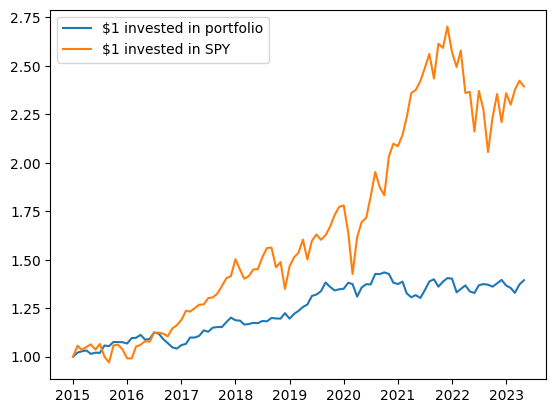

In [ ]:
portfolio_price = portfolio_performance(ticker_group, plot=True)

In [ ]:
market_price = yf.download("SPY", start="2015-01-01", end="2023-04-30", interval = "1mo")["Adj Close"]
market_price /= market_price[0]
portfolio_price, market_price

[*********************100%***********************]  1 of 1 completed


(Date
 2015-01-01    1.000000
 2015-02-01    1.020894
 2015-03-01    1.027076
 2015-04-01    1.031996
 2015-05-01    1.013999
                 ...   
 2023-01-01    1.366936
 2023-02-01    1.353842
 2023-03-01    1.329104
 2023-04-01    1.372418
 2023-05-01    1.393948
 Length: 101, dtype: float64,
 Date
 2015-01-01    1.000000
 2015-02-01    1.056204
 2015-03-01    1.034996
 2015-04-01    1.049839
 2015-05-01    1.063336
                 ...   
 2022-12-01    2.209442
 2023-01-01    2.359172
 2023-02-01    2.299856
 2023-03-01    2.376062
 2023-04-01    2.423232
 Name: Adj Close, Length: 100, dtype: float64)

In [ ]:
dji_price = yf.download('^DJI', start = "2015-01-01", end = "2023-04-30", interval="1mo")['Adj Close']
dji_price /= dji_price[0]
nasdaq_price = yf.download('^IXIC', start = "2015-01-01", end = "2023-04-30", interval="1mo")['Adj Close']
nasdaq_price /= nasdaq_price[0]
dji_price

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Date
2015-01-01    1.000000
2015-02-01    1.056379
2015-03-01    1.035606
2015-04-01    1.039358
2015-05-01    1.049271
                ...   
2022-12-01    1.931101
2023-01-01    1.985793
2023-02-01    1.902522
2023-03-01    1.938494
2023-04-01    1.986499
Name: Adj Close, Length: 100, dtype: float64

# Monthly Return of S&P 500 vs Portfolio

Below is the annual return of S&P500 and the portfolio

In [ ]:
portfolio_price = portfolio_price.shift(-1)

In [ ]:
# r_m = market_price.shift(-1)/market_price - 1
r_m = market_price.shift(-1)/market_price - 1
r_m.dropna(inplace=True)
r_m.describe()

count    99.000000
mean      0.010068
std       0.046766
min      -0.129987
25%      -0.014558
50%       0.014320
75%       0.035288
max       0.133611
Name: Adj Close, dtype: float64

In [ ]:
portfolio_price

Date
2015-01-01    1.020894
2015-02-01    1.027076
2015-03-01    1.031996
2015-04-01    1.013999
2015-05-01    1.020405
                ...   
2023-01-01    1.353842
2023-02-01    1.329104
2023-03-01    1.372418
2023-04-01    1.393948
2023-05-01         NaN
Length: 101, dtype: float64

In [ ]:
r_p = portfolio_price.shift(-1)/portfolio_price - 1
r_p.dropna(inplace=True)
r_m = r_m[:len(r_p)]
r_p.describe()

count    99.000000
mean      0.003322
std       0.018559
min      -0.050256
25%      -0.006013
50%       0.002975
75%       0.014311
max       0.039671
dtype: float64

In [ ]:
sd_m = np.std(r_m)
sd_p = np.std(r_p)
leverage = sd_m / sd_p

leveraged_portfolio = portfolio_price.copy()

for i in range(len(leveraged_portfolio) - 1):
    r = portfolio_price[i + 1]/portfolio_price[i] - 1
    leveraged_portfolio[i + 1] = leveraged_portfolio[i] * (1 + leverage * r)

leveraged_portfolio

Date
2015-01-01    1.020894
2015-02-01    1.036471
2015-03-01    1.048984
2015-04-01    1.002887
2015-05-01    1.018853
                ...   
2023-01-01    1.951034
2023-02-01    1.861203
2023-03-01    2.014042
2023-04-01    2.093654
2023-05-01         NaN
Length: 101, dtype: float64

In [ ]:
r_p_leveraged = leveraged_portfolio.shift(-1)/leveraged_portfolio - 1
r_p_leveraged.dropna(inplace=True)
r_p_leveraged.describe()

count    99.000000
mean      0.008370
std       0.046766
min      -0.126635
25%      -0.015152
50%       0.007496
75%       0.036060
max       0.099964
dtype: float64

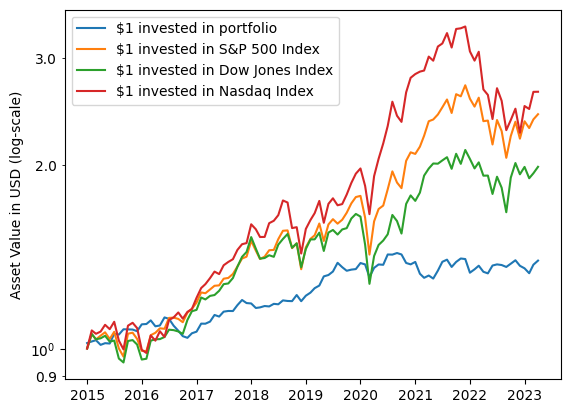

In [ ]:
from matplotlib import pyplot as plt, ticker as mticker

plt.plot(portfolio_price, label="$1 invested in portfolio")
# plt.plot(leveraged_portfolio, label=f"$1 invested in leveraged portfolio (x{round(leverage, 3)})")
plt.plot(market_price, label=f"$1 invested in S&P 500 Index")
plt.plot(dji_price, label=f"$1 invested in Dow Jones Index")
plt.plot(nasdaq_price, label=f"$1 invested in Nasdaq Index")
plt.semilogy()
plt.ylabel("Asset Value in USD (log-scale)")
ax = plt.gca()
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())

plt.legend(loc='best')

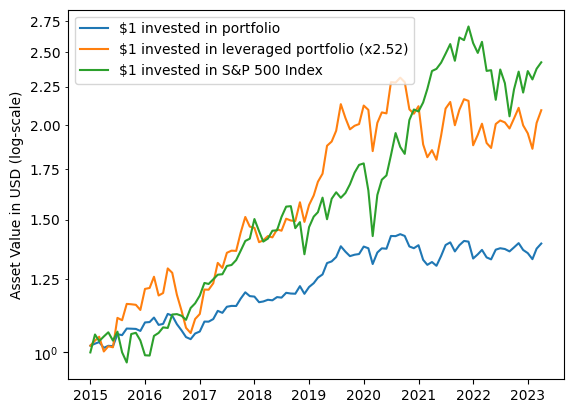

In [ ]:
plt.plot(portfolio_price, label="$1 invested in portfolio")
plt.plot(leveraged_portfolio, label=f"$1 invested in leveraged portfolio (x{round(leverage, 3)})")
plt.plot(market_price, label=f"$1 invested in S&P 500 Index")
plt.semilogy()
plt.ylabel("Asset Value in USD (log-scale)")

ax = plt.gca()
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())

plt.legend(loc='best')

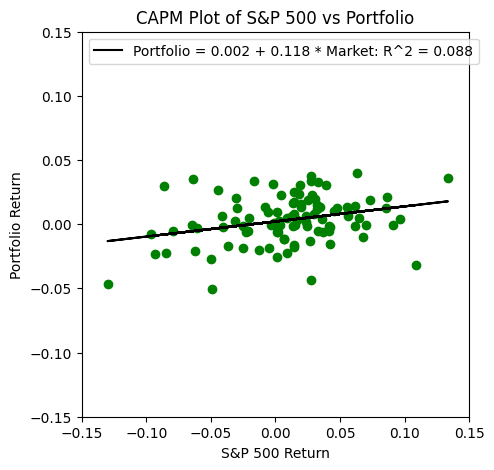

In [ ]:
r_m_np = np.array(r_m).reshape(-1, 1)
r_p_np = np.array(r_p).reshape(-1, 1)
model = LinearRegression().fit(r_m_np, r_p_np)

alpha, beta, r_squared = model.intercept_[0], model.coef_[0][0], model.score(r_m_np, r_p_np)

y_pred=model.predict(r_m_np)
fig, ax = plt.subplots(figsize = (5, 5))
            
plt.scatter(r_m, r_p,color='g') 
plt.plot(r_m, y_pred,color='k', label =\
                    f"Portfolio = {round(alpha, 3)} + {round(beta, 3)} * Market: R^2 = {round(r_squared, 3)}") 

ax.set_xlim([-0.15, 0.15])
ax.set_ylim([-0.15, 0.15])
plt.xlabel("S&P 500 Return")
plt.ylabel("Portfolio Return")
plt.title(f"CAPM Plot of S&P 500 vs Portfolio")
plt.legend(loc="upper left")

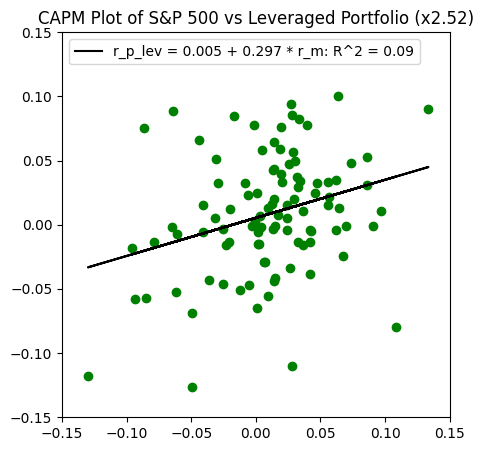

In [ ]:
r_m_np = np.array(r_m).reshape(-1, 1)
r_p_lev_np = np.array(r_p_leveraged).reshape(-1, 1)
model = LinearRegression().fit(r_m_np, r_p_lev_np)

alpha, beta, r_squared = model.intercept_[0], model.coef_[0][0], model.score(r_m_np, r_p_lev_np)

y_pred=model.predict(r_m_np)
fig, ax = plt.subplots(figsize = (5, 5))
            
plt.scatter(r_m_np, r_p_lev_np,color='g') 
plt.plot(r_m_np, y_pred,color='k', label =\
                    f"r_p_lev = {round(alpha, 3)} + {round(beta, 3)} * r_m: R^2 = {round(r_squared, 2)}") 
ax.set_xlim([-0.15, 0.15])
ax.set_ylim([-0.15, 0.15])
plt.title(f"CAPM Plot of S&P 500 vs Leveraged Portfolio (x{round(leverage, 3)})")
plt.legend(loc="upper left")

In [ ]:
r_p, r_m

(Date
 2015-01-01    0.006055
 2015-02-01    0.004791
 2015-03-01   -0.017439
 2015-04-01    0.006318
 2015-05-01   -0.001207
                 ...   
 2022-11-01   -0.020655
 2022-12-01   -0.009579
 2023-01-01   -0.018272
 2023-02-01    0.032589
 2023-03-01    0.015687
 Length: 99, dtype: float64,
 Date
 2015-01-01    0.056204
 2015-02-01   -0.020080
 2015-03-01    0.014341
 2015-04-01    0.012856
 2015-05-01   -0.025054
                 ...   
 2022-11-01   -0.061936
 2022-12-01    0.067768
 2023-01-01   -0.025143
 2023-02-01    0.033135
 2023-03-01    0.019852
 Name: Adj Close, Length: 99, dtype: float64)

In [ ]:
r_m.to_csv("Monthly_S&P_500_Return.csv")
r_p.to_csv("Monthly_Portfolio_Return.csv")

(-15.0, 15.0)

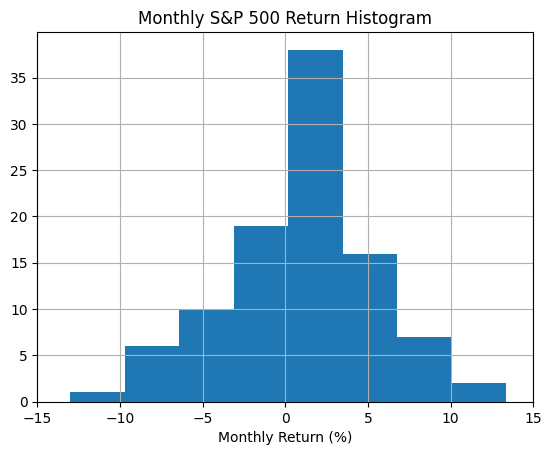

In [ ]:
(r_m * 100).hist(bins=8)
plt.xlabel("Monthly Return (%)")
plt.title("Monthly S&P 500 Return Histogram")
plt.xlim([-15, 15])

(-15.0, 15.0)

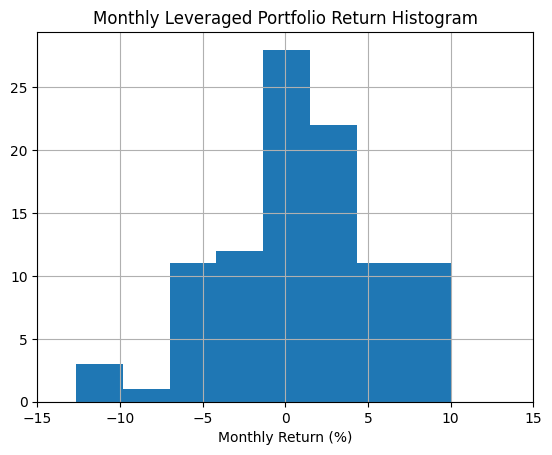

In [ ]:
(r_p_leveraged * 100).hist(bins=8)
plt.xlabel("Monthly Return (%)")
plt.title("Monthly Leveraged Portfolio Return Histogram")
plt.xlim([-15, 15])

(-10.0, 10.0)

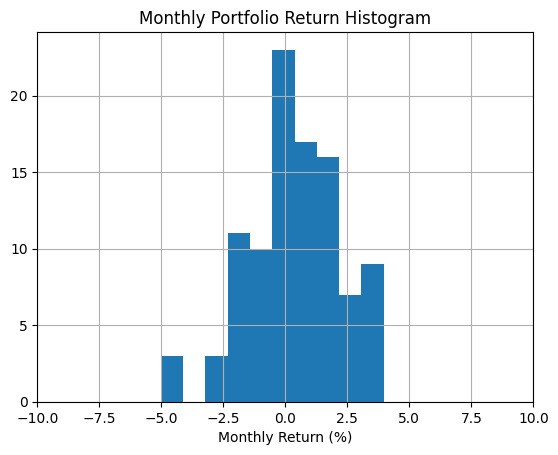

In [ ]:
(r_p * 100).hist()
plt.xlabel("Monthly Return (%)")
plt.title("Monthly Portfolio Return Histogram")
plt.xlim([-10, 10])

(-10.0, 10.0)

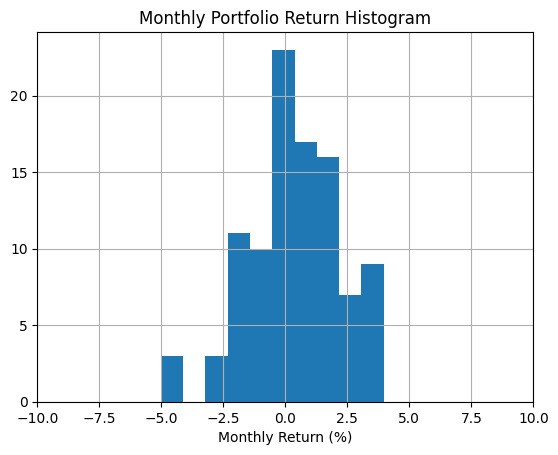

In [ ]:
(r_p * 100).hist()
plt.xlabel("Monthly Return (%)")
plt.title("Monthly Portfolio Return Histogram")
plt.xlim([-10, 10])

Text(0.5, 0.98, 'Monthly Portfolio Return Histogram')

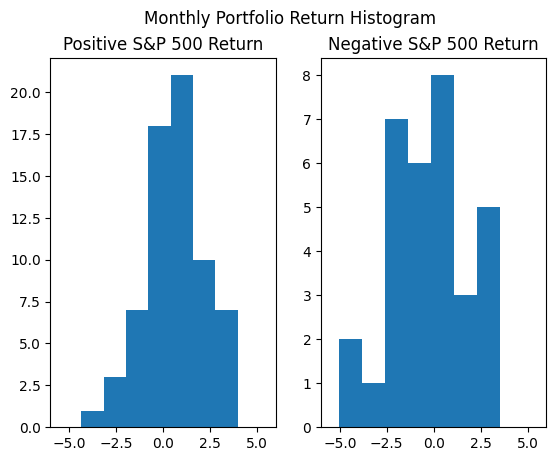

In [ ]:
r_p_up = r_p[r_m > 0]
r_p_down = r_p[r_m <= 0]
bins=7
fig, ax = plt.subplots(1, 2)
ax[0].hist(100 * r_p_up, bins=bins)
ax[0].set_title("Positive S&P 500 Return")
ax[0].set_xlim([-6, 6])
ax[1].hist(100 * r_p_down, bins=bins)
ax[1].set_title("Negative S&P 500 Return")
ax[1].set_xlim([-6, 6])

fig.suptitle("Monthly Portfolio Return Histogram")

In [ ]:
r_p_up.describe()

count    67.000000
mean      0.005962
std       0.016585
min      -0.043672
25%      -0.002113
50%       0.006055
75%       0.016299
max       0.039671
dtype: float64

In [ ]:
r_p_down.describe()

count    32.000000
mean     -0.002205
std       0.021370
min      -0.050256
25%      -0.018390
50%      -0.001789
75%       0.010131
max       0.035273
dtype: float64

In [ ]:
r_m_up = r_m[r_m >= 0]
r_m_down = r_m[r_m < 0]

In [ ]:
r_m_up.describe()

count    67.000000
mean      0.034916
std       0.028475
min       0.001197
25%       0.014307
50%       0.027806
75%       0.046541
max       0.133611
Name: Adj Close, dtype: float64

In [ ]:
r_m_down.describe()

count    32.000000
mean     -0.041958
std       0.032545
min      -0.129987
25%      -0.062395
50%      -0.033825
75%      -0.019246
max      -0.000826
Name: Adj Close, dtype: float64

In [ ]:
market_price[:-3], portfolio_price[:-4], leveraged_portfolio[:-4]

(Date
 2015-01-01    1.000000
 2015-02-01    1.056204
 2015-03-01    1.034996
 2015-04-01    1.049839
 2015-05-01    1.063336
                 ...   
 2022-09-01    2.055121
 2022-10-01    2.231281
 2022-11-01    2.355321
 2022-12-01    2.209442
 2023-01-01    2.359172
 Name: Adj Close, Length: 97, dtype: float64,
 Date
 2015-01-01    1.020894
 2015-02-01    1.027076
 2015-03-01    1.031996
 2015-04-01    1.013999
 2015-05-01    1.020405
                 ...   
 2022-09-01    1.360971
 2022-10-01    1.377710
 2022-11-01    1.395766
 2022-12-01    1.366936
 2023-01-01    1.353842
 Length: 97, dtype: float64,
 Date
 2015-01-01    1.020894
 2015-02-01    1.036471
 2015-03-01    1.048984
 2015-04-01    1.002887
 2015-05-01    1.018853
                 ...   
 2022-09-01    1.980268
 2022-10-01    2.041640
 2022-11-01    2.109063
 2022-12-01    1.999293
 2023-01-01    1.951034
 Length: 97, dtype: float64)

In [ ]:
# Average Annual Return


term = range(1, 8)
x = {
    f"{2023 - y}" : [
        (market_price[:-3][-2] / market_price[:-3][-2 - 12*y]) ** (1/y) - 1,
        (portfolio_price[:-4][-2] / portfolio_price[:-4][-2 - 12*y]) ** (1/y) - 1,
        (leveraged_portfolio[:-4][-2] / leveraged_portfolio[:-4][-2 - 12*y]) ** (1/y) - 1
    ]
    for y in term
}
x = pd.DataFrame(x, index = ["S&P 500", "Portfolio", f"Leveraged (x{round(leverage, 3)})"])
x

,2022,2021,2020,2019,2018,2017,2016
S&P 500,-0.182632,0.026145,0.076301,0.131236,0.093245,0.113113,0.114100
Portfolio,-0.025130,-0.002681,0.004148,0.034008,0.028560,0.043397,0.035927
Leveraged (x2.52),-0.071877,-0.017545,-0.001293,0.076436,0.063753,0.103485,0.083792


Text(0, 0.5, 'Annual Return (%)')

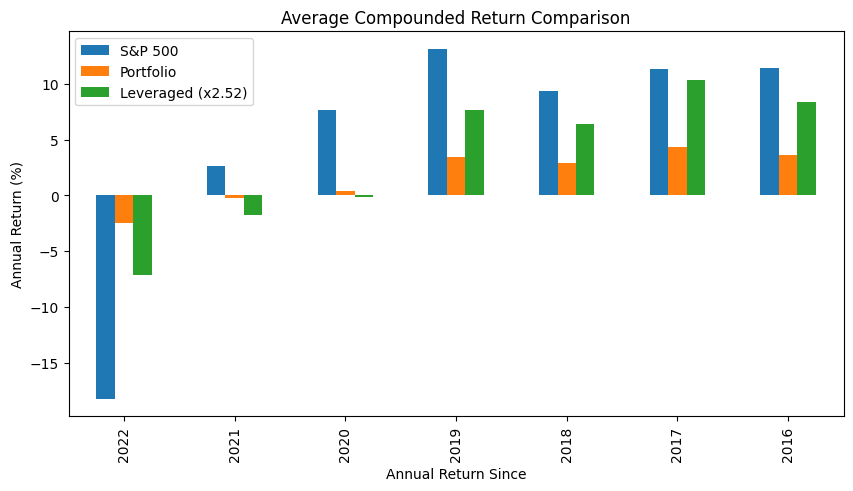

In [ ]:
x = x * 100
x.transpose().plot.bar(figsize=(10, 5))
plt.title("Average Compounded Return Comparison")
plt.xlabel("Annual Return Since")
plt.ylabel("Annual Return (%)")

In [ ]:
# Average Annual Return
term = range(1, 8)
x = {
    f"{2023 - y}\n{round(100 * ((portfolio_price[-2 - 12*(y - 1)] / portfolio_price[-2 - 12*y]) - 1), 2)} %" : [
        100 * ((portfolio_price[-2 - 12*(y - 1)] / portfolio_price[-2 - 12*y]) - 1),
    ]
    for y in term
}
x = pd.DataFrame(x, index = ["Portfolio Return"])
x

,2022\n4.32 %,2021\n1.42 %,2020\n-2.86 %,2019\n6.91 %,2018\n8.04 %,2017\n6.07 %,2016\n1.78 %
Portfolio Return,4.315227,1.424728,-2.856389,6.91157,8.035539,6.067124,1.782332


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '2022\n4.32 %'),
  Text(1, 0, '2021\n1.42 %'),
  Text(2, 0, '2020\n-2.86 %'),
  Text(3, 0, '2019\n6.91 %'),
  Text(4, 0, '2018\n8.04 %'),
  Text(5, 0, '2017\n6.07 %'),
  Text(6, 0, '2016\n1.78 %')])

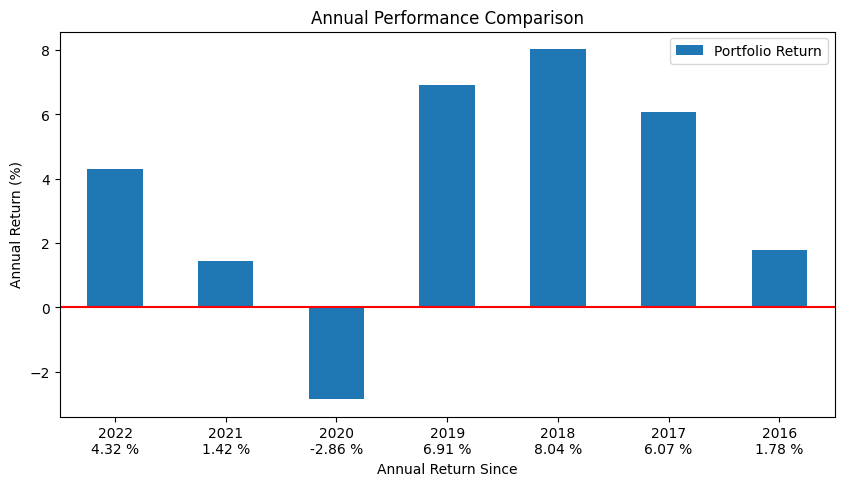

In [ ]:
x.transpose().plot.bar(figsize=(10, 5))
plt.title("Annual Performance Comparison")
plt.ylabel("Annual Return (%)")
plt.xlabel("Annual Return Since")
plt.axhline(y=0, color='r', linestyle='-')
plt.xticks(rotation='horizontal')

<BarContainer object of 99 artists>

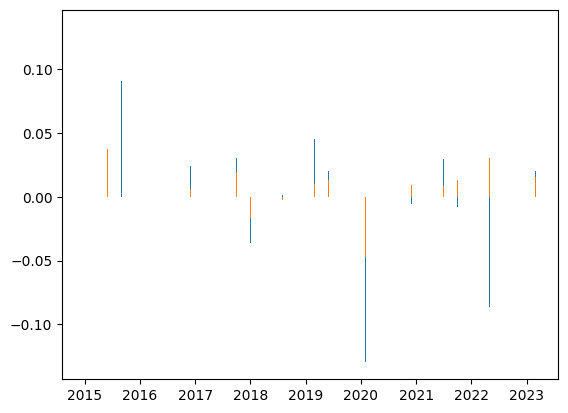

In [ ]:
combined = pd.DataFrame({"S&P500" : r_m, "Portfolio" : r_p})

ax = plt.axes()
plt.bar(x=combined.index, height = r_m, label = "S&P 500")
plt.bar(x=combined.index, height = r_p, label = "Portfolio")

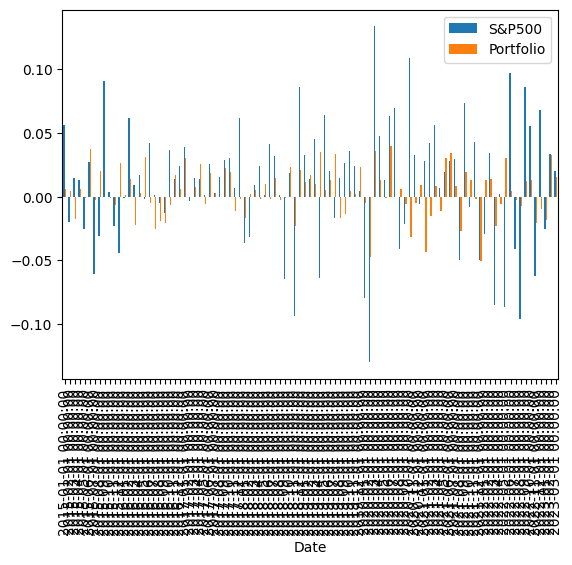

In [ ]:
ax = combined.plot.bar()


In [ ]:
r_m_semann = market_price.shift(-6)/market_price - 1
r_m_semann.describe()

count    94.000000
mean      0.057088
std       0.092353
min      -0.203265
25%       0.001119
50%       0.059929
75%       0.108880
max       0.312674
Name: Adj Close, dtype: float64

In [ ]:
r_p_semann = portfolio_price.shift(-6)/portfolio_price - 1
r_p_semann.describe()

count    94.000000
mean      0.019675
std       0.042404
min      -0.089370
25%      -0.003303
50%       0.025192
75%       0.049401
max       0.119247
dtype: float64

In [ ]:
r_m_semann = r_m_semann[::6].dropna()
r_p_semann = r_p_semann[::6].dropna()

In [ ]:
combined = pd.DataFrame({"S&P500" : r_m_semann, "Portfolio" : r_p_semann})
combined.index

DatetimeIndex(['2015-01-01', '2015-07-01', '2016-01-01', '2016-07-01',
               '2017-01-01', '2017-07-01', '2018-01-01', '2018-07-01',
               '2019-01-01', '2019-07-01', '2020-01-01', '2020-07-01',
               '2021-01-01', '2021-07-01', '2022-01-01', '2022-07-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

ValueError: ignored

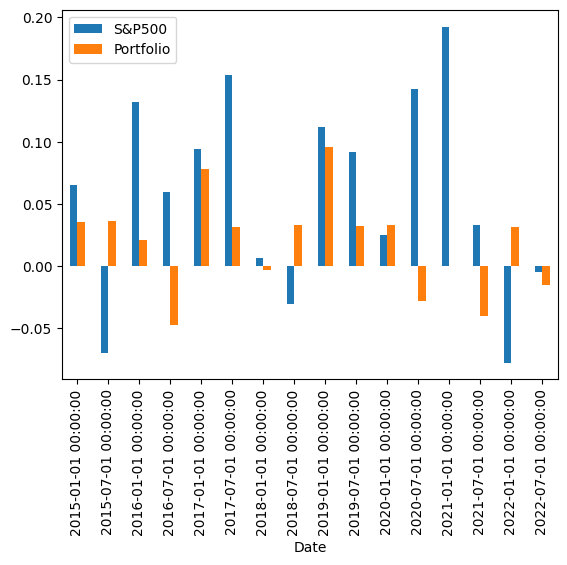

In [ ]:
semann_index = []
for year in range(2016, 2023):
    semann_index.extend([f"{year} 1H", f"{year} 2H"])

combined = pd.DataFrame({"S&P500" : r_m_semann, "Portfolio" : r_p_semann})

ax = combined.plot.bar()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = semann_index

ax.set_xticklabels(labels)
# plt.bar(x = semann_index, height = combined["S&P500"])
# plt.bar(x = semann_index + 0.5, height = combined["Portfolio"])

In [ ]:
market_price[-1], portfolio_price

# LSTM Predictor of S&P 500 Returns

We will use LSTM time series model to first predict the upcoming monthly returns of the S&P500 index. Subsequently, we will long/short S&P500 or invest in market-neutral fund based on the expected monthly returns

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
df=pd.read_csv('')
length=df['Open'].length()
training_set = df.iloc[:length*0.8, 1:2].values
test_set = df.iloc[length*0.8:, 1:2].values
]
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)\
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [ ]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 100, batch_size = 32)

In [ ]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualising the results
plt.plot(df.loc[800:, ‘Date’],dataset_test.values, color = ‘red’, label = ‘Real TESLA Stock Price’)
plt.plot(df.loc[800:, ‘Date’],predicted_stock_price, color = ‘blue’, label = ‘Predicted TESLA Stock Price’)
plt.xticks(np.arange(0,459,50))
plt.title('S&P 500 Prediction')
plt.xlabel('Time')
plt.ylabel('S&P 500 Index')
plt.legend()
plt.show()